In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




# Volatility timing

Volatility timing is about the other side of the optimal weight we derived

$$x_t=\frac{E_t[r^e_{t+1}]}{\gamma Var_t(r^e_{t+1})}$$

We now focus exclusively on the denominator. The treatment here follows

>ALAN MOREIRA, TYLER MUIR, Volatility-Managed Portfolios, Journal of Finance, August 2017
https://doi.org/10.1111/jofi.12513


The key is to construct a good measure for $ Var_t(r^e_{t+1})$

* Using daily data for month t, construct the market return "realized variance" during month t
   
   $$rv_t=\sum_{d \in days~ in ~month ~t}\frac{(r_d- \overline{r})^2}{N_{days}},$$
   
 where $\overline{r}$ is the average return within the month
   
  * Buy the market at the closing price of month t according to the rule:
   
   $$x_t=\frac{c}{rv_t},$$
   
where $c$ is some constant.
   
  * Hold the position for a month
  
  * The returns of the strategy are given by
  
  

 
  $$ r^{VolTiming}_{t+1}=(1-\frac{c}{rv_t})r_{f,t+1}+\frac{c}{rv_t}r^{MKT}_{t+1}$$


* One could use a variety of other volatility estimators to implement the strategy

   - VIX 
   - GARCH based forecasts
   - Regression forecasts based lagged rv
   - Regression forecasts based lagged rv and VIX
   

**Download data from WRDS**

(if you have credentials)

In [8]:
import datetime as dt
import wrds
import psycopg2 
from dateutil.relativedelta import *


# connect with their server
#conn=wrds.Connection()

# get the value-weighted market returns and date from the data base crsp.dsi
mkt_d = conn.raw_sql("""
                      select a.date, a.vwretd
                      from crsp.dsi as a
                      """) 
# get the risk-free rate
rf_d = conn.raw_sql("""
                      select a.date, a.rf
                      from ff.factors_daily as a
                      """)

mkt_d=mkt_d.set_index(['date'])

mkt_d=mkt_d.set_index(pd.to_datetime(mkt_d.index),'date')

rf_d=rf_d.set_index(['date'])

rf_d=rf_d.set_index(pd.to_datetime(rf_d.index),'date')

# we merge

daily=mkt_d.merge(rf_d,how='left',left_index=True,right_index=True)
# save data locally
#daily.to_pickle('../../assets/data/daily.pkl')


NameError: name 'conn' is not defined

Alternatively simply import from Gihub by substituting the address below

In [10]:

daily=pd.read_pickle('https://github.com/amoreira2/Lectures/blob/main/assets/data/daily.pkl?raw=true')


## **Constructing monthly realized variance from daily data**


You basically use pandas time series function that shifts all dates to the end of the month, so this way you are technically grouping by the end of the month day.

Now  I use groupby `endofmonth` to put  all returns of given "year-month" pair together (i.e. with the same date)



In [11]:
from pandas.tseries.offsets import MonthEnd
endofmonth=daily.index+MonthEnd(0)
endofmonth

DatetimeIndex(['1925-12-31', '1926-01-31', '1926-01-31', '1926-01-31',
               '1926-01-31', '1926-01-31', '1926-01-31', '1926-01-31',
               '1926-01-31', '1926-01-31',
               ...
               '2020-12-31', '2020-12-31', '2020-12-31', '2020-12-31',
               '2020-12-31', '2020-12-31', '2020-12-31', '2020-12-31',
               '2020-12-31', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=25046, freq=None)

So I can just compute the variance of this group (say 1/1/2020,1/2/2020,...1/31/2020) will all be 1/31/2020

This will return the daily variance in that month

So the output will be one realized variance for each month

<AxesSubplot:xlabel='date'>

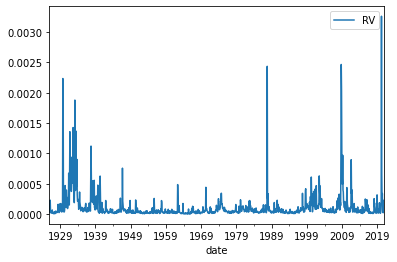

In [12]:


# We denote `realized variance` for the market return as `RV`
RV=daily[['vwretd']].groupby(endofmonth).var()
# rename column to clarify
RV=RV.rename(columns={'vwretd':'RV'})
RV.plot()

Note how clustered volatility is

that clustering that the strategy exploits

If variance was high this month, probably will be high next month too

## **From signal to weights**

* weight on the market:

$$x_t=c\frac{1}{rv_t}$$

* weight on the risk-free rate: $1-x_t$

* $c$ controls how levered is the strategy on average.

* As we saw before all timing strategies involved some in and out of the market, but you also need to determine the average position. That is the role of $c$.

* There are many ways to choose c

* while c does not impact the strategy Sharpe Ratio, it impacts the amount of leverage that the strategy will take

* Here lets keep it simple and simply choose it so that the position on the market is 1 on average

$$E[x_t]=E[c\frac{1}{rv_t}]=1$$

implies $c=\frac{1}{E[\frac{1}{rv_t}]}$


1.0

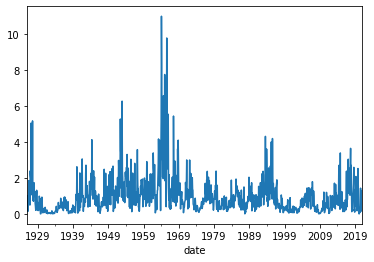

In [13]:
# calculate weights for the risky assets (market)
c=1/(1/RV.RV).mean()
RV['Weight']=c/RV.RV

RV.Weight.plot()
RV.Weight.mean()

You see that leverage gets really high. 

As high as 10!

You can see that in your position in the risk-free rate which exactly mirrors that



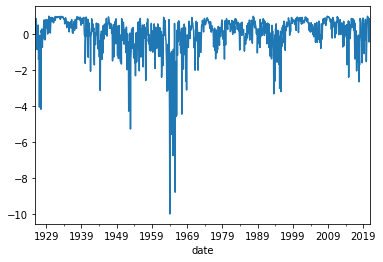

In [14]:
# plot the weights on the risk-free rate
(1-RV.Weight).plot()
plt.show()

## **Aggregate daily returns to monthly returns**

* Since the strategy will trade monthly, we now need to construct monthly returns

* we do that by cumulating daily returns within a month


In [15]:
# aggregate daily returns to monthly returns
Ret=(1+daily).groupby(endofmonth).prod()-1
# rename columns to clarify
Ret.tail()

,vwretd,rf
date,,
2020-08-31,0.068549,0.0
2020-09-30,-0.034910,0.0
2020-10-31,-0.020180,0.0
2020-11-30,0.123639,0.0
2020-12-31,0.044672,0.0


In [16]:

# Merge Ret (monthly return) with RV (realized variance and weights)
df=RV.merge(Ret,how='left',left_index=True,right_index=True)
df.tail()

,RV,Weight,vwretd,rf
date,,,,
2020-08-31,0.000024,1.440905,0.068549,0.0
2020-09-30,0.000228,0.151360,-0.034910,0.0
2020-10-31,0.000154,0.224363,-0.020180,0.0
2020-11-30,0.000090,0.384961,0.123639,0.0
2020-12-31,0.000027,1.290376,0.044672,0.0


## **Construct strategy returns**

* Now to construct the strategy return recall that we use the relaized variance in month t to buy the market at the closing of month t and earn the return accrued in month t+1

* So we need to lag our weights, or lead the returns

* I will call the strategy as $\textbf{VMS}$ (Volatility Managed Strategy)

In [17]:
# compare with the weight before . It simply shifts the weght from month t to month t+1
df.Weight.shift(1).tail()

date
2020-08-31    0.473877
2020-09-30    1.440905
2020-10-31    0.151360
2020-11-30    0.224363
2020-12-31    0.384961
Name: Weight, dtype: float64

In [18]:
# now construct the return of the strategy
df['VMS']=df.Weight.shift(1)*df.vwretd+(1-df.Weight.shift(1))*df.rf

We can see the cumulative returns of the market and the volatility managed strategy

<AxesSubplot:xlabel='date'>

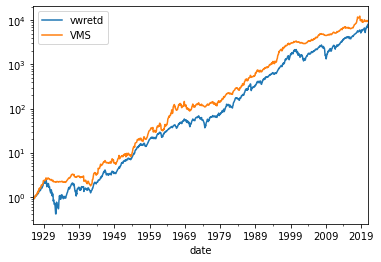

In [19]:
(df[['vwretd','VMS']]+1).cumprod().plot(logy=True)


**Volatility is more stable**



<AxesSubplot:xlabel='date'>

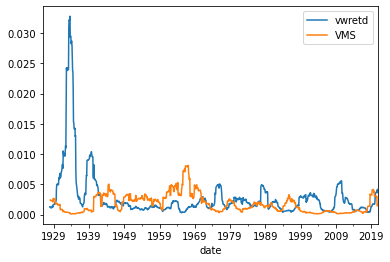

In [20]:
df[['vwretd','VMS']].rolling(window=24).var().plot()

**Average returns over 2 year periods**

<AxesSubplot:xlabel='date'>

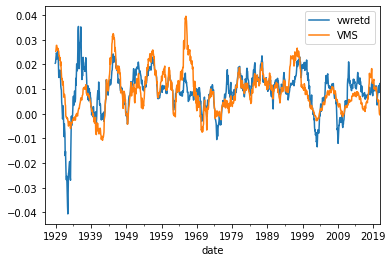

In [22]:
df[['vwretd','VMS']].rolling(window=36).mean().plot()

**Sharpe ratio**

The VMS strategy ends up with a 20% higher Sharpe Ratio

In [31]:
(df[['vwretd','VMS']].subtract(df.rf,axis=0).mean()/df[['vwretd','VMS']].std())*12**0.5

vwretd    0.431226
VMS       0.513687
dtype: float64

**Tail risk**

The VMS bears substantially less tail risk as well

We can look at the the percentile 0.5% of the return distribution

In [33]:
df[['vwretd','VMS']].quantile(q=0.005)

vwretd   -0.187543
VMS      -0.133776
Name: 0.005, dtype: float64

**Things to try**


- How well it works with VIX instead of RV?
- How well it works with standard deviation instead of variance
- How well it works if we put leverage limits
- How well it works if we combine an expected return signal with the volatility signal?